In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df


df = pd.read_csv('./titanic_train.csv')

y_df = df['Survived']
X_df= df.drop('Survived', axis=1)
X_df = transform_features(X_df)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=11)

In [2]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [3]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=200)
lr_clf.fit(X_train , y_train)

pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


## predict_proba()

In [4]:
pred_proba = lr_clf.predict_proba(X_test)

pred_proba[:3]

array([[0.4622624 , 0.5377376 ],
       [0.87876959, 0.12123041],
       [0.87722282, 0.12277718]])

In [5]:
pred.reshape(-1,1)[:3]

array([[1],
       [0],
       [0]])

In [6]:
import numpy as np

pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
pred_proba_result[:3]

array([[0.4622624 , 0.5377376 , 1.        ],
       [0.87876959, 0.12123041, 0.        ],
       [0.87722282, 0.12277718, 0.        ]])

## Binarizer

In [7]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,   2],
     [ 2,  0,   0],
     [ 0,  1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)                     
bin = binarizer.fit_transform(X)
bin

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [8]:
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
pred_proba_1[:3]

array([[0.5377376 ],
       [0.12123041],
       [0.12277718]])

In [9]:
custom_threshold = 0.5

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)
custom_predict[:3]

array([[1.],
       [0.],
       [0.]])

In [10]:
get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [11]:
custom_threshold = 0.4

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [12]:
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold)
        custom_predict = binarizer.fit_transform(pred_proba_c1)
        
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)
        print()

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361

임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033

임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869

임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541

임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377



## precision_recall_curve()

In [13]:
from sklearn.metrics import precision_recall_curve

lr_clf = LogisticRegression(max_iter=200)
lr_clf.fit(X_train , y_train)

pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]
pred_proba_class1[:5]

array([0.5377376 , 0.12123041, 0.12277718, 0.11755966, 0.14473053])

In [14]:
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )

print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)
print()
print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])
print()
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 11개:', thr_index)
print('샘플용 11개의 임곗값: ', np.round(thresholds[thr_index], 2))
print()
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
반환된 precisions 배열의 Shape: (166,)
반환된 recalls 배열의 Shape: (166,)

thresholds 5 sample: [0.01157964 0.05285578 0.06228381 0.06364646 0.06863153]
precisions 5 sample: [0.34078212 0.34269663 0.34463277 0.34659091 0.34857143]
recalls 5 sample: [1. 1. 1. 1. 1.]

샘플 추출을 위한 임계값 배열의 index 11개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 11개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]

샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


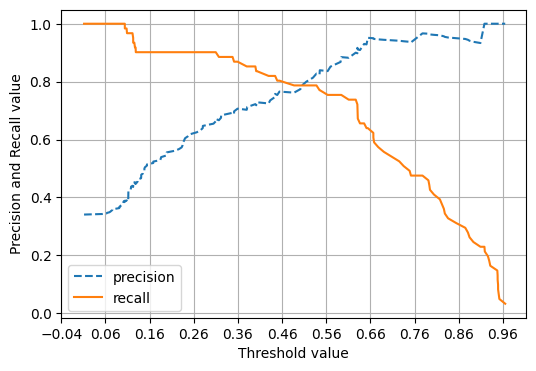

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    plt.figure(figsize=(6,4))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )